In [1]:
#%matplotlib notebook
from z_utils.Tracker import Tracker
from z_utils.init_detector_05 import *
from DiffuseMap import *

C:\python\platform\Platform_w_one_points3D
initParam...
video_in video_frames/video_15//
video_out ./output/video_frames/video_15//video_frames/video_15.mp4
path_out_for_DM_images ./output/video_frames/video_15//
Running on device: cuda:0
initCaptureObj...
initTracker...
start_ind    1
True
00022.jpg
был 1920 1080
стал 1920 1080
00023.jpg
был 1920 1080
стал 1920 1080
00024.jpg
[INFO] Facenet_pytorch took 0.264716 seconds
no init_000: 0
[INFO] Facenet_pytorch took 0.246144 seconds
1920 1080
00025.jpg
[INFO] Facenet_pytorch took 0.276703 seconds


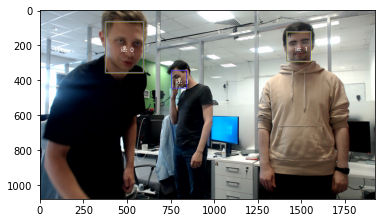

Draw


KeyboardInterrupt: 

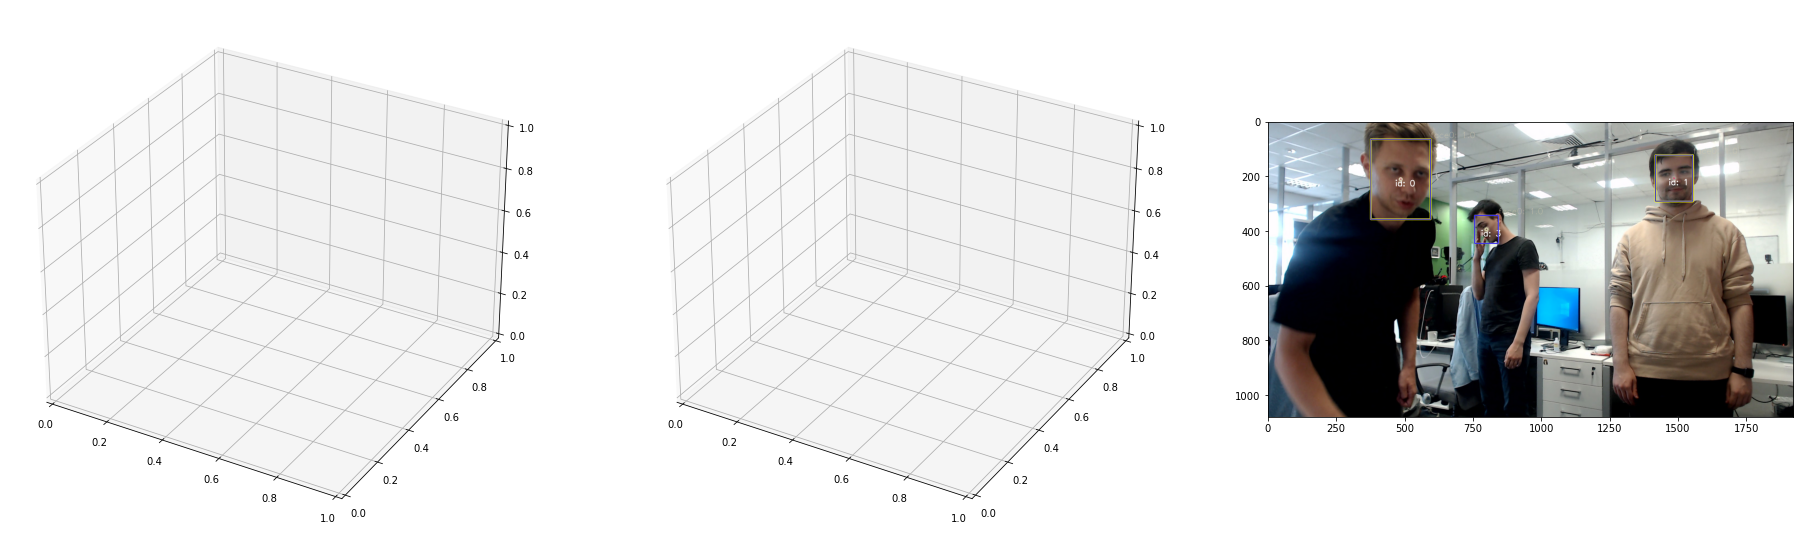

In [4]:
class ROS_Linker:
    def __init__(self):
        self.CaptureObject=None
        self.list_params=None
        self.video_out=None
        self.Tracker=None
        self.diffuse_map = None

    def initParams(self):
        print('initParam...')

        path_in = 'video_frames/video_15/' #Папка в которой лежат либо фотографии либо видео
        file_name = ''   #Для папки с фоторгафиями оставляем пустой. Для видео пишем ТОЛЬКО название видео.
        video_name = file_name + '.mp4'
        path_out = './output/'
        clear_dir_00(path_out) #Очищаем всю папку path_out
        path_out_for_DM_images = path_out + path_in + '/'  # куда складывать картинки с диффузной картой

        #Сохранение для папки с кадрами.
        if len(file_name) == 0:
            name = path_in
            ext = '.mp4'
            self.video_in = path_in + file_name + '/'
            self.video_out = path_out + name + '/' + name[:-1] + ext
        #Сохранение для видео.
        else:
            name = path_in
            ext = '.mp4'
            self.video_in = path_in + video_name
            self.video_out = path_out + name + '/' + file_name + ext

        if not os.path.exists(path_out_for_DM_images):
            os.makedirs(path_out_for_DM_images)

        clear_dir_00(path_out_for_DM_images) # Очищаем папку куда сложили дифф карту
        clear_dir_00('save_fig/')

        print('video_in', self.video_in)
        print('video_out', self.video_out)
        print('path_out_for_DM_images', path_out_for_DM_images)


        input_type_flag = 1  # Тип входных данных:0 - видео, 1 - папка с файлами, 2 - rtsp-поток (тут веб-камера сейчас), 3 - ftp-поток (не реализовано), 4 - ROS
        flag_cut_and_save_objects = 0  # вырезаем объекты в ббоксах
        flag_save_tr_mat = 0  # собираем ли траектории в мат
        flag_debug = 0  # надо ли сохранять картинки нарезанные. Не используется
        ########################################################
        p_opt_flow = 0.99  # 0- идем по предикт, 1- идем по оптикал флоу
        ########### Настраиваем тут предиктор ##################
        predictor_type = 4  # 0 - yolo, 1 - detectron2 (cadet), 2 - detectron2 (pedet), 3 - face_detection, 4 - facenet_pytorch
        ########################################################
        video_adapter = 1 # Выбор видеоадаптера: 0 - CPU, 1 - GPU
        ########################################################
        add_holistic = 1 # 0 - выключить скелет, 1 - включить скелет
        ########################################################
        show_3Dpoints_holistic = 1 # 1 - Будет рисоваться скелет с фрагментами в папке save_fig 
        ########################################################
        show3D_one_points = 0 # 1 - Будет рисоваться только 1 точка головы с фрагментами в папке save_fig 
        ########################################################
        show_BBOX = 1 # Флаг для отрисовки ББокса и превью.
        ########################################################
        show_diffusion = 0 # 0 - выключена дифф мапа, 1 - включена на запись
        ########################################################
        quality_width = 1920  #Какую ширину подаем изображению
        ########################################################

        thr_confidence = 0.99 #Отвечает за удаления ложных айдишников

        #Используем предиктор 4 - фейснет пайторч
        main_predictor = None
        if predictor_type == 0:
            main_predictor = detector_cocos(thr_confidence)
        elif predictor_type == 1:
            main_predictor = detector_detectron_cadet(model='cadet')
        elif predictor_type == 2:
            main_predictor = detector_detectron_cadet(model='pedet')
        elif predictor_type == 3:
            main_predictor = detector_detectron_cadet()
        elif predictor_type == 4:
            main_predictor = detector_facenet_pytorch(thr_confidence, video_adapter)
        else:
            pass
        
        #Для потока в вебкамеры, заменяем self.video_in на 0. Сохранять фото
        if input_type_flag == 2:
            self.video_in = 0
            self.video_out = path_out + path_in + 'rtsp_video' + ext
            
        dscr_TL_00 = descr_745_init(11)  # 11 - фейснет
        ####################################

        self.list_params = {
            'path_out': path_out,
            'dscr_TL_00': dscr_TL_00, #Выбор дескриптора. Используем 11 - Facenet, получаеим вектора
            'detector_01': main_predictor,  # детектор для распознавалки объектов
            'detector_02': main_predictor,  # predictor_010,  # ела для распознавалки объектов
            'double_detect_flag': 0,  # если 1, то в фоновом режиме без трека распознаем объекты предиктором 2
            'input_type_flag': input_type_flag, # Выбор модели загрузки файлов/видео/вебкамера
            'predictor_type': predictor_type, #Используем предиктор фейснет_пайторч
            'diffuse_map': self.diffuse_map, 
            'DM_save': None,
            'flag_debug': flag_debug,
            'add_holistic': add_holistic, #Включить скелет или нет
            'path_out_for_DM_images': path_out_for_DM_images,
            'show_diffusion': show_diffusion, #Флаг для дифф карты
            'show_3Dpoints_holistic': show_3Dpoints_holistic, #флаг для 3Д точек
            'show3D_one_points': show3D_one_points, #Флаг для 3Д одной точки
            'show_BBOX': show_BBOX,
            'video_adapter': video_adapter, #Флаг выбора CPU/GPU
            'quality_width': quality_width, #Флаг выбора качества
            'resize_coef': 16/9, #Формат изображения
            'compensaition_index' : 8,
            'cannals_hist': 0,  ### 0- гистограмма hue для идентификации объекта, 2- гистограмма яркости

            'flag_classify_traj': 3,  ### классификатор траекторий: 0 - CNN, 1 - lstm, 2- mll, 3 - simple classify
            'path_to_w_classify_traj': 'classify_trajs\\InpOut001_mll_weights_25eps.h5',
            # None, # путь к весам классификатора траекторий
            'flag_prediction': 0,  ### lstm обучена не на том=>  флаг=0 #предсказатель траектории
            'path_to_prediction': None,  # 'q00_person.h5'# путь к весам предсказателя траекторий #

            'thr_color_features': 0.3, #Порог отвечает за сравнение косинусных расстояний. Сравнивает расстояния больше порога
            'check_period': 5,  #Отвечает за количество списков с векторами # forget_horizont_vert #30 - хорошо работает
            'debug_visu': 1,
            'border_edge': 5,  # относительно каких границ ищем новые объекты, used in add_new_object
            'r_edge': 1,  # относительно   границ ищем новые объекты  1- внутри области, -1 снаружи, used in add_new_object

            'flag_cut_and_save_objects': flag_cut_and_save_objects,
            'flag_save_tr_mat': flag_save_tr_mat,
            'l_forget_history': 15,
            'thr_confidence': 0.999, #отвечает за то, чтобы добавлялись в список векторизаций только хорошие детекции

            'manual_thr_radius': 2000, # %%%%% Радиус для поиска лица %%%%%

            'minsize': 40,  # минимальный размер лица. НЕ ИСПОЛЬЗУЕТСЯ для фейснет_пайторч
            'threshold': [0.6, 0.7, 0.7],  # three steps's threshold
            'factor': 0.709,  # scale factor 0.709
            'margin': 44, #НЕ ИСПОЛЬЗУЕТСЯ для фейснет_пайторч
            'thr_measure_hue_optflow2predict': None,
            'thr_add_new': 200, # Радиус. Используется в add_new_object
            'thr_correct_opt_flow': p_opt_flow * 350,
            ### если OF скакнуло от предикта больше чем thr_correct_opt_flow, верим предикту
            'prefix_ind_save_0': 10500000,
            'p_opt_flow': p_opt_flow,  # 0- идем по предикт, 1- идем по оптикал флоу
            'start_ind': 1,
            'class_to_interest': np.array(range(10)), #Не очень понял
            'debug_count': -15  # 25*60*5  # 5 минут
        }
        # self.video_out = path_out + filename_out
        #На шаффл История - 10. Чек период - 20
        #На сортированный. История - 10. Чек период - 10

    def init_diffuse_map(self):
        self.diffuse_map = DiffuseMap('pickles/facenet_pytorch.pickle', 0.8, True, 'pickles/DM_vector512.pickle')


    def initCaptureObject(self):
        print('initCaptureObj...')
        self.CaptureObject = Caption_Class_01(self.video_in, self.list_params['input_type_flag'], 1920) #Качество для вебки

    def initTracker(self):
        print('initTracker...')
        self.Tracker= Tracker(self.CaptureObject,self.video_out,self.list_params)
        self.Tracker.InitTracker()

    def TrackImage(self,image=None):
        if self.list_params['input_type_flag'] == 4:
            self.UpdateImage(image)

        return self.Tracker.TrackImage()
    
    def ShutdownTracker(self): #Функция отвечает за сохранение видео
        
        return self.Tracker.ShutdownTracker()
    
    def UpdateImage(self,image):
        self.CaptureObject.updateImageROS(image)
       

    
linker=ROS_Linker()#инициализируем класс
#Сначала инициализируем параметры, связанных с путями до файлов. Затем часть кода для сохранения файлов, если берем видео, или берем папку с файлами
#Далее идет часть кода, где происходит выбор флагов для определенных компонентов кода. Выбираем предиктор, используем фейснет_пайторч. 
#Для потока с вебкамеры заменяем self.video_in. Далее происходит выбор дескриптора, для получения векторизации
#Далее загружаем много параметров, которые используются в коде. Описание есть у всех. Функции далее описаны ниже.
linker.init_diffuse_map()#инициализируем дифф. мапу
linker.initParams()#загружаем все параметры
linker.initCaptureObject()#Загружаем путь к входному видео или в зависимости от флага, переключаемся на камеру
cap_2 = None
if linker.list_params['input_type_flag'] == 4:#Берем входное видео из ROSA
    cap_2 = cv2.VideoCapture(1)
    ret, image = cap_2.read()
    linker.UpdateImage(image)
linker.initTracker()

while linker.CaptureObject.isOpened():
    start = time.time()
    if linker.list_params['input_type_flag'] == 4:
        ret, image = cap_2.read()
        track_result = linker.TrackImage(image)
    else:
        track_result = linker.TrackImage()#Запуск трекера
        result  = {}
        for i in track_result:
            if i['owned'][-1] > 0.5 and i['age'] > 3:
                result[i['id']] = {'x': round(i['3D_points'][0], 4), 'y': round(i['3D_points'][1], 4), 'z': round(i['3D_points'][2], 4)}
            elif i['owned'][-1] < 0.5 and i['age'] > 3:
                result[i['id']] = {'x': round(i['3DV_lost'][0], 4), 'y': round(i['3DV_lost'][1], 4), 'z': round(i['3DV_lost'][2], 4)}
        print(result)    
    end = time.time()
    print("[INFO] фул тайм {:.6f} seconds".format(end - start))
        #Что мы получаем в track_result:
        #age - Сколько фрагментов этот человек есть в кадре. age_lost - Сколько кадров фрагмента нет в кадре
        #id - Номер задетекченного человека. #history - Записывает центр Ббокса в каждом кадре объекта.
        #history_X - тоже самое. owned - записывает 1 - если объект есть в кадре, 0 - если пропал из кадра.
        #Используется для обновление истории. Если много нулей, то пропадает из детекта человек.
        #holistic - Записывает 3д точки скелета объекта. descriptor_ - Записывает 512 значений, используется для детекта лица.
        #descriptor_ - векторизация каждого id в каждом кадре объекта. w - ширина Ббокса, всегда одно значение у каждого id.
        #h - высота Ббокса, всегда одно значение у каждого id. class_trajectory - Используется для классификации траектории.
        #radius - Радиус поиска id, если id потерялся из кадра. N14 -используется для проверки. Не важное значение
        #init_posit - центр Ббокса в текущем кадре.



    if cv2.waitKey(10) == 27:  #
        break

#linker.ShutdownTracker() #Сохранение видео
cv2.destroyAllWindows() 